# ***Lab 4 - Linear models***

In [1]:
import arviz as az
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from cmdstanpy import CmdStanModel

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Normal model - no predictors

In [2]:
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d = d[d.age >= 18] # Just adults 
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [3]:
height_mu = np.mean(d.height)
height_std = np.std(d.height)
print(f"Mean height: {height_mu}\nStandard deviation of height: {height_std}")

Mean height: 154.5970926136364
Standard deviation of height: 7.73132668454304


## Task 1. Prior predictive checks

In [4]:
model_ppc = CmdStanModel(stan_file="height_1_ppc.stan")

INFO:cmdstanpy:found newer exe file, not recompiling


In [5]:
R = 1000
mu_mu, mu_sig, sig_lbd = 175, 15, 0.0667

sim = model_ppc.sample(data={"mu_mu": mu_mu, "mu_sig": mu_sig, "sig_lbd": sig_lbd}, iter_sampling=R, iter_warmup=0, chains=1, fixed_param=True, seed=29042020, refresh=R)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


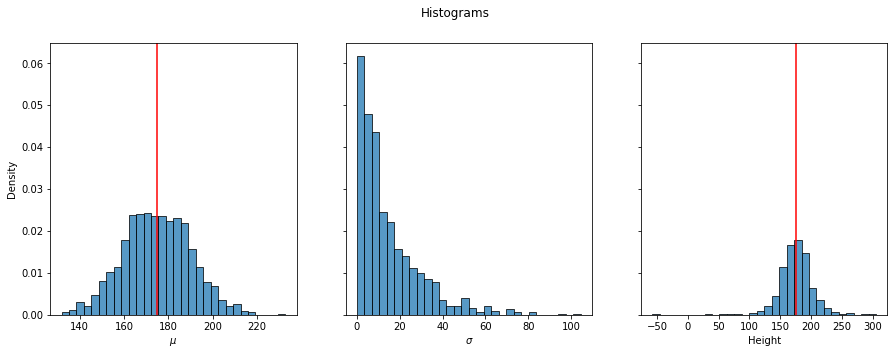

In [6]:
sim_pd = sim.draws_pd()

_, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
sns.histplot(data=sim_pd, x="mu", stat="density", ax=ax[0], bins=30)
sns.histplot(data=sim_pd, x="sig", stat="density", ax=ax[1], bins=30)
sns.histplot(data=sim_pd, x="height", stat="density", ax=ax[2], bins=30)
ax[0].axvline(np.mean(sim_pd.mu), color="red")
ax[2].axvline(np.mean(sim_pd.height), color="red")
ax[0].set_xlabel("$\mu$")
ax[1].set_xlabel("$\sigma$")
ax[2].set_xlabel("Height")
plt.suptitle("Histograms")
plt.show()

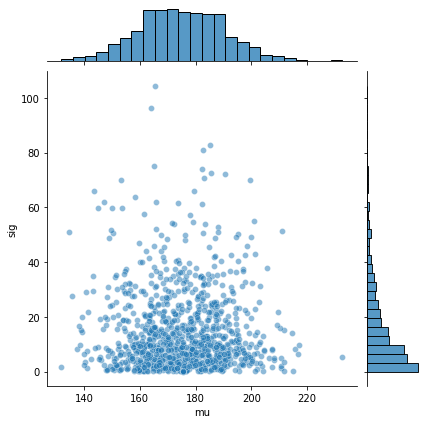

In [7]:
sns.jointplot(data=sim_pd, x="mu", y="sig", alpha=0.5)
plt.show()

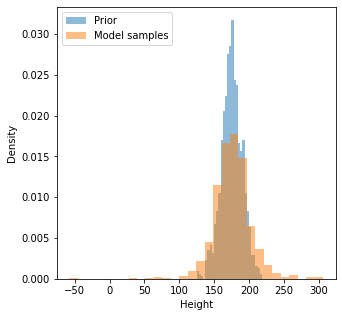

In [8]:
height_prior = np.random.normal(mu_mu, mu_sig, size=R)

plt.figure(figsize=(5, 5))
plt.hist(height_prior, bins=30, alpha=0.5, density=True, label="Prior")
plt.hist(sim_pd.height, bins=30, alpha=0.5, density=True, label="Model samples")
plt.xlabel("Height"), plt.ylabel("Density")
plt.legend()
plt.show()

**Observed data is possible to obtain using priors.**

## Task 2. Model fit and evaluation

In [9]:
model_1_fit = CmdStanModel(stan_file="height_1_fit.stan")

INFO:cmdstanpy:found newer exe file, not recompiling


In [10]:
fit = model_1_fit.sample(data={"N": len(d), "heights": d.height.values, "mu_mu": mu_mu, "mu_sig": mu_sig, "sig_lbd": sig_lbd}, seed=28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▍         | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████████▋ | 00:01 Iteration: 1600 / 2000 [ 80%]  (Sampling)




chain 1 |██████████| 00:03 Sampling completed                       
chain 2 |██████████| 00:03 Sampling completed                       
chain 3 |██████████| 00:03 Sampling completed                       
chain 4 |██████████| 00:03 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


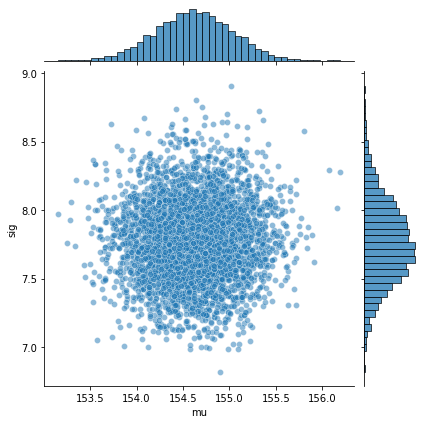

In [11]:
fit_pd = fit.draws_pd()

sns.jointplot(data=fit_pd, x="mu", y="sig", alpha=0.5)
plt.show()

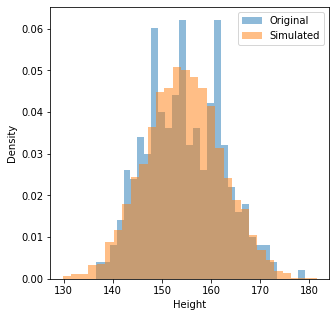

In [12]:
plt.figure(figsize=(5, 5))
plt.hist(d.height, bins=30, alpha=0.5, density=True, label="Original")
plt.hist(fit_pd.height, bins=30, alpha=0.5, density=True, label="Simulated")
plt.xlabel("Height"), plt.ylabel("Density")
plt.legend()
plt.show()

**The model fits the data pretty well.**

## Task 3. Adding predictor to the model - weight

In [13]:
d["c_weight"] = d.weight - d.weight.mean()
data_sim = {"N": 50, "weight": np.linspace(d.c_weight.min(), d.c_weight.max()), "mu_mu": mu_mu, "mu_sig": mu_sig, "sig_lbd": sig_lbd}
print(data_sim)

{'N': 50, 'weight': array([-13.91943352, -13.26797358, -12.61651364, -11.9650537 ,
       -11.31359376, -10.66213383, -10.01067389,  -9.35921395,
        -8.70775401,  -8.05629407,  -7.40483413,  -6.75337419,
        -6.10191425,  -5.45045432,  -4.79899438,  -4.14753444,
        -3.4960745 ,  -2.84461456,  -2.19315462,  -1.54169468,
        -0.89023474,  -0.23877481,   0.41268513,   1.06414507,
         1.71560501,   2.36706495,   3.01852489,   3.66998483,
         4.32144477,   4.9729047 ,   5.62436464,   6.27582458,
         6.92728452,   7.57874446,   8.2302044 ,   8.88166434,
         9.53312428,  10.18458421,  10.83604415,  11.48750409,
        12.13896403,  12.79042397,  13.44188391,  14.09334385,
        14.74480379,  15.39626373,  16.04772366,  16.6991836 ,
        17.35064354,  18.00210348]), 'mu_mu': 175, 'mu_sig': 15, 'sig_lbd': 0.0667}


## Task 4. Prior predictive checks

In [14]:
model_ppc = CmdStanModel(stan_file="height_2a_ppc.stan")

INFO:cmdstanpy:found newer exe file, not recompiling


In [16]:
sim = model_ppc.sample(data=data_sim, iter_sampling=R, iter_warmup=0, chains=1, refresh=R, fixed_param=True, seed=29042020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


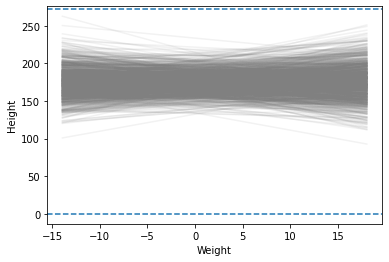

In [17]:
sim_pd = sim.draws_pd()
alpha_samples = sim_pd.alpha.values
beta_samples = sim_pd.beta_.values

for i in range(len(alpha_samples)):
    plt.plot(data_sim["weight"], alpha_samples[i] + beta_samples[i] * data_sim["weight"], color="gray", alpha=0.1)

plt.axhline(y=0, ls="--"), plt.axhline(y=272, ls="--") # Tallest man ever - Robert Wadlow, 272 cm
plt.xlabel("Weight"), plt.ylabel("Height")
plt.show()

**Possible predicted heights are consistent with minum and maximum heights observed in nature.**

## Task 5. Modifying prior

In [18]:
model_ppc = CmdStanModel(stan_file="height_2b_ppc.stan")

INFO:cmdstanpy:compiling stan file /home/Lab4/height_2b_ppc.stan to exe file /home/Lab4/height_2b_ppc
INFO:cmdstanpy:compiled model executable: /home/Lab4/height_2b_ppc
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/Lab4/height_2b_ppc.hpp /home/Lab4/height_2b_ppc.stan
Warning in '/home/Lab4/height_2b_ppc.stan', line 3, column 2: Declaration of
    arrays by placing brackets after a variable name is deprecated and will
    be removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Warning in '/home/Lab4/height_2b_ppc.stan', line 10, column 2: Declaration of
    arrays by placing brackets after a variable name is deprecated and will
    be removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignore

In [19]:
sim = model_ppc.sample(data=data_sim, iter_sampling=R, iter_warmup=0, chains=1, refresh=R, fixed_param=True, seed=29042020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


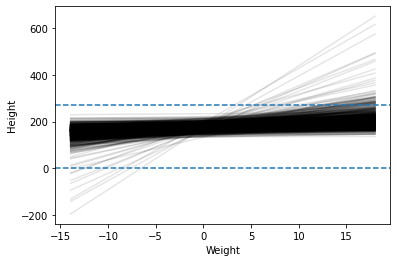

In [20]:
sim_pd = sim.draws_pd()
alpha_samples = sim_pd.alpha.values
beta_samples = sim_pd.beta_.values

for i in range(len(alpha_samples)):
    plt.plot(data_sim["weight"], alpha_samples[i] + beta_samples[i] * data_sim["weight"], color="black", alpha=0.1)

plt.axhline(y=0, ls="--")
plt.axhline(y=272, ls="--")

plt.xlabel("Weight")
plt.ylabel("Height")
plt.show()

**Possible predicted heights are consistent with minimum and maximum heights observed in nature in most cases. However, there are some inconsistencies for edge values of weights.**

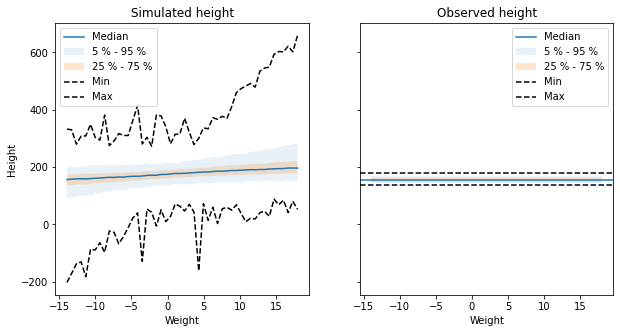

In [25]:
percentiles = [0, 5, 25, 50, 75, 95, 100]
sim_percentiles = np.percentile(sim_pd.filter(regex="^height").to_numpy(), percentiles, axis=0)
obs_percentiles = np.percentile(d.height, percentiles, axis=0)

_, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
ax[0].plot(data_sim["weight"], sim_percentiles[3], label="Median")
ax[0].fill_between(data_sim["weight"], sim_percentiles[1], sim_percentiles[5], alpha=0.1, label="5 % - 95 %")
ax[0].fill_between(data_sim["weight"], sim_percentiles[2], sim_percentiles[4], alpha=0.2, label="25 % - 75 %")
ax[0].plot(data_sim["weight"], sim_percentiles[0], "k--", label="Min")
ax[0].plot(data_sim["weight"], sim_percentiles[-1], "k--", label="Max")
ax[0].set_xlabel("Weight"), ax[0].set_ylabel("Height")
ax[0].set_title("Simulated height")
ax[0].legend()

ax[1].axhline(y=obs_percentiles[3], label="Median")
ax[1].fill_between(data_sim["weight"], obs_percentiles[1], obs_percentiles[5], alpha=0.1, label="5 % - 95 %")
ax[1].fill_between(data_sim["weight"], obs_percentiles[2], obs_percentiles[4], alpha=0.2, label="25 % - 75 %")
ax[1].axhline(y=obs_percentiles[0], color="black", ls="--", label="Min")
ax[1].axhline(y=obs_percentiles[-1], color="black", ls="--", label="Max")
ax[1].set_xlabel("Weight"), ax[0].set_ylabel("Height")
ax[1].set_title("Observed height")
ax[1].legend()
plt.show()

**Observed data is definitely possible within the prior model. Basic percentiles areas nearly overlap for simulated and observed height. However, to be more accurate, the model needs some additional data, specific for the problem.**

## Task 6. Fitting and evaluating model

In [26]:
model_2_fit = CmdStanModel(stan_file="height_2_fit.stan")

INFO:cmdstanpy:compiling stan file /home/Lab4/height_2_fit.stan to exe file /home/Lab4/height_2_fit
INFO:cmdstanpy:compiled model executable: /home/Lab4/height_2_fit
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/Lab4/height_2_fit.hpp /home/Lab4/height_2_fit.stan
Warning in '/home/Lab4/height_2_fit.stan', line 3, column 2: Declaration of
    arrays by placing brackets after a variable name is deprecated and will
    be removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Warning in '/home/Lab4/height_2_fit.stan', line 30, column 4: Declaration of
    arrays by placing brackets after a variable name is deprecated and will
    be removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attri

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status



chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)



chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)


chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


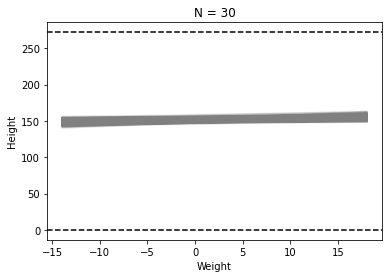

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▍         | 00:01 Status
chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██████████| 00:04 Sampling completed                       
chain 2 |██████████| 00:04 Sampling completed                       

chain 3 |██████████| 00:04 Sampling completed
chain 4 |██████████| 00:04 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


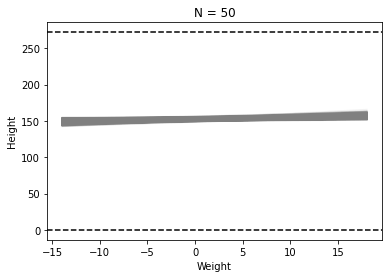

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▍         | 00:00 Status


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)



chain 1 |███████▋  | 00:01 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |█████████ | 00:01 Iteration: 1700 / 2000 [ 85%]  (Sampling)
chain 1 |██████████| 00:01 Iteration: 1900 / 2000 [ 95%]  (Sampling)











chain 1 |██████████| 00:02 Sampling completed                       
chain 2 |██████████| 00:02 Sampling completed
chain 3 |██████████| 00:02 Sampling completed                       
chain 4 |██████████| 00:02 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


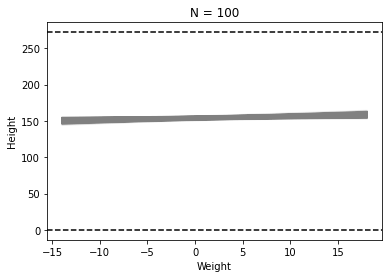

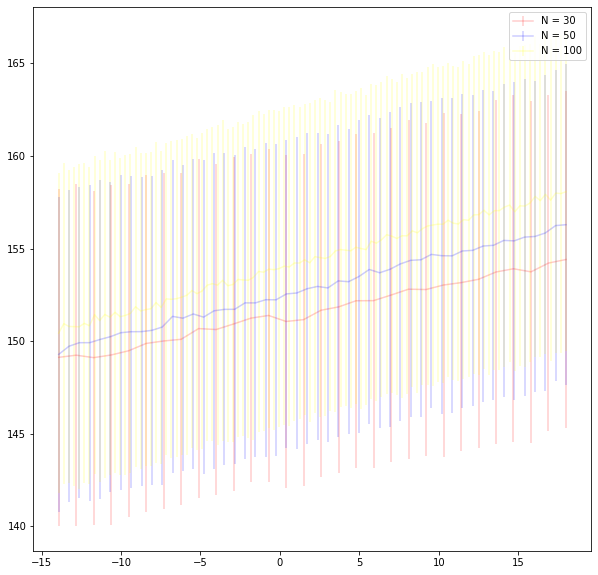

In [37]:
mu, sig = [], []

for N in (30, 50, 100):
    data_fit = {"N": N, "heights": d.height.values[:N], "weight": np.linspace(d.c_weight.min(), d.c_weight.max(), num=N), "mu_mu": mu_mu, "mu_sig": mu_sig, "sig_lbd": sig_lbd}
    fit = model_2_fit.sample(data=data_fit, seed=28052020)
    fit_pd = fit.draws_pd()

    mu.append(fit_pd.iloc[:, -N:].mean())
    sig.append(fit_pd.iloc[:, -N:].std())

    alpha_samples = fit_pd.alpha.values
    beta_samples = fit_pd.beta_.values

    for i in range(len(alpha_samples)):
        plt.plot(data_fit["weight"], alpha_samples[i] + beta_samples[i] * data_fit['weight'], "gray", alpha=0.1)

    plt.axhline(y=0, color='black', ls='--')
    plt.axhline(y=272, color='black', ls='--')
    plt.xlabel("Weight"), plt.ylabel("Height"), plt.title(f"N = {N}")
    plt.show()

plt.figure(figsize=(10, 10))
colors = ["red", "blue", "yellow"]

for i, N in enumerate((30, 50, 100)):
    plt.errorbar(x=np.linspace(d.c_weight.min(), d.c_weight.max(), num=N), y=mu[i], yerr=sig[i], alpha=0.2, color=colors[i], label=f"N = {N}")

plt.legend()
plt.show()

**The larger the number of samples $N$, the more narrow the uncertainty area.**

**Observed data is definitely possible within the posterior model. It is more accurate than the prior model - as expected.**

**The larger the number of samples $N$, the more narrow the error area.**

## Task 7. Extending the model

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status




chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)
chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)





chain 1 |██████████| 00:06 Sampling completed                       
chain 2 |██████████| 00:06 Sampling completed                       
chain 3 |██████████| 00:06 Sampling completed                       
chain 4 |██████████| 00:06 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


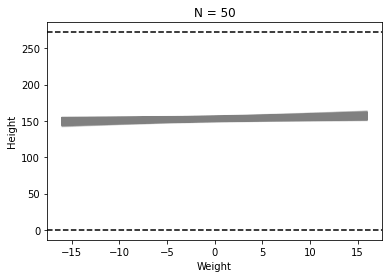

In [39]:
N = 50
weight = np.linspace(d.c_weight.min(), d.c_weight.max(), num=N)
weight = weight - weight.mean()
data_fit = {"N": N, "heights": d.height.values[:N], "weight": weight, "mu_mu": mu_mu, "mu_sig": mu_sig, "sig_lbd": sig_lbd}
fit = model_2_fit.sample(data=data_fit, seed=28052020)
fit_pd = fit.draws_pd()

alpha_samples = fit_pd.alpha.values
beta_samples = fit_pd.beta_.values

for i in range(len(alpha_samples)):
    plt.plot(data_fit["weight"], alpha_samples[i] + beta_samples[i] * data_fit["weight"], 'gray', alpha=0.1)

plt.axhline(y=0, color='black', ls='--')
plt.axhline(y=272, color='black', ls='--')

plt.xlabel("Weight"), plt.ylabel("Height"), plt.title(f"N = {N}")
plt.show()

**The model still works pretty well. In such case, the interpretation of $\alpha$ is value when predictor is equal to the mean value.**

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)




chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)




chain 1 |██████████| 00:06 Sampling completed                       
chain 2 |██████████| 00:06 Sampling completed                       
chain 3 |██████████| 00:06 Sampling completed                       
chain 4 |██████████| 00:06 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


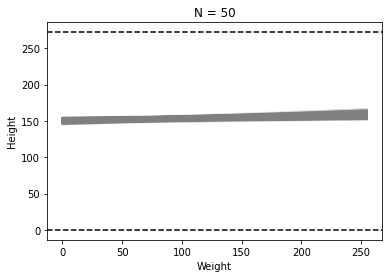

In [40]:
N = 50
weight = np.linspace(d.c_weight.min(), d.c_weight.max(), num=N)
weight = weight - weight.mean()
data_fit = {"N": N, "heights": d.height.values[:N], "weight": weight**2, "mu_mu": mu_mu, "mu_sig": mu_sig, "sig_lbd": sig_lbd}
fit = model_2_fit.sample(data=data_fit, seed=28052020)
fit_pd = fit.draws_pd()

alpha_samples = fit_pd.alpha.values
beta_samples = fit_pd.beta_.values

for i in range(len(alpha_samples)):
    plt.plot(data_fit["weight"], alpha_samples[i] + beta_samples[i] * data_fit["weight"], 'gray', alpha=0.1)

plt.axhline(y=0, color='black', ls='--')
plt.axhline(y=272, color='black', ls='--')

plt.xlabel("Weight"), plt.ylabel("Height"), plt.title(f"N = {N}")
plt.show()

**The set of lines have been shifted towards the mean value. The model is still good.**